## Movie Studio Strategy Analysis


## Business Understanding
Overview

This project is designed to aid a company's venture into the movie production industry by launching a new studio. Through comprehensive data analysis, the project will identify current trends and provide actionable insights from box office data. This information will guide the company in determining the types of movies that are most successful in today’s market, thereby supporting strategic content creation and maximizing box office returns

The Problem Statement

The company needs to pinpoint what types of movies are most successful in the current market to propel the new studio's launch. Specifically, we aim to:
1.Identify the most successful movie genres at the box office

2.Analyze the relationship between production scale and profitability

3.Evaluate the impact of release timing on movie success

4.Explore how movie ratings influence box office performance

In [51]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 
import os

%matplotlib inline


In [52]:
# Extracting the zipped imdb file
import zipfile

zip_file_path =  "../zippedData/im.db.zip"
extracted_dir = 'unzipped/imdb_db'
db_file_path = os.path.join(extracted_dir, 'im.db')

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
    print(f"Successfully extracted {len(zip_ref.namelist())} file(s) to {extracted_dir}")

Successfully extracted 1 file(s) to unzipped/imdb_db


In [53]:
# Connect to SQLite database
conn = sqlite3.connect(db_file_path)

# List tables
tables = pd.read_sql("""
                     SELECT name
                     FROM sqlite_master
                     WHERE type='table';
                     """, conn)
print("Tables in the IMDb database:")
print(tables)

Tables in the IMDb database:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [54]:
## merge required tables then convert it to a dataframe
#Select relevant information from movie_basics table
#JOIN to movie_ratings

imdb = pd.read_sql("""
SELECT primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
FROM movie_basics
JOIN movie_ratings
USING(movie_id)
""",conn)
print("shape of imdb:", imdb.shape)
imdb.head()

shape of imdb: (73856, 6)


,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43
2,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [55]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    73856 non-null  object 
 1   start_year       73856 non-null  int64  
 2   runtime_minutes  66236 non-null  float64
 3   genres           73052 non-null  object 
 4   averagerating    73856 non-null  float64
 5   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 3.4+ MB


In [56]:
imdb.describe()

,start_year,runtime_minutes,averagerating,numvotes
count,73856.000000,66236.000000,73856.000000,7.385600e+04
mean,2014.276132,94.654040,6.332729,3.523662e+03
std,2.614807,208.574111,1.474978,3.029402e+04
min,2010.000000,3.000000,1.000000,5.000000e+00
25%,2012.000000,81.000000,5.500000,1.400000e+01
50%,2014.000000,91.000000,6.500000,4.900000e+01
75%,2016.000000,104.000000,7.400000,2.820000e+02
max,2019.000000,51420.000000,10.000000,1.841066e+06


In [57]:
# percentage of missing values in imdb
imdb.isnull().mean()*100

primary_title       0.000000
start_year          0.000000
runtime_minutes    10.317374
genres              1.088605
averagerating       0.000000
numvotes            0.000000
dtype: float64

In [58]:
#  handle rows with missing values 
runtime_median = imdb["runtime_minutes"].median()
imdb["runtime_minutes"].fillna(runtime_median, inplace=True)
imdb.dropna(subset=['genres',], inplace=True)
# confirming no missing values
imdb.isna().sum()

primary_title      0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
numvotes           0
dtype: int64

In [59]:
# duplicates in imdb
imdb.duplicated().value_counts()


False    73052
dtype: int64

In [60]:
# drop duplicated rows in the imdb 
imdb.drop_duplicates(inplace=True)
imdb.duplicated().value_counts()

False    73052
dtype: int64

In [61]:
imdb['title_clean'] = imdb['primary_title'].str.strip().str.lower()
print(f"Unique cleaned titles: {imdb['title_clean'].nunique()} / {len(imdb)} total rows")


Unique cleaned titles: 69197 / 73052 total rows


In [62]:
imdb.shape

(73052, 7)

In [63]:
## Load box office Movie data
gross = pd.read_csv("../zippedData/bom.movie_gross.csv.gz")
# Check for shape of dataframe
print("Shape of gross:", gross.shape)
gross.head()


Shape of gross: (3387, 5)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [64]:
gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [65]:
# changing foreign gross to float datatype
gross["foreign_gross"] = pd.to_numeric(gross["foreign_gross"],errors="coerce")

In [66]:
# Create a total gross column by summing domestic and foreign gross
gross['total_gross'] = gross['domestic_gross'] + gross['foreign_gross']

In [67]:
# Clean title
gross['title_clean'] = gross['title'].str.replace(r"\s*\(\d{4}\)", "", regex=True).str.strip().str.lower()


In [68]:
# Checking for missing values in gross
gross.isnull().mean()*100

title              0.000000
studio             0.147623
domestic_gross     0.826690
foreign_gross     40.005905
year               0.000000
total_gross       40.832595
title_clean        0.000000
dtype: float64

In [69]:

# Check how many movies have complete financial data
print("Movies with complete financial data:", gross['total_gross'].notnull().sum())
print("Movies missing financial data:", gross['total_gross'].isnull().sum())

# For our analysis, we might want to focus on movies with complete financial data
gross = gross.dropna(subset=['total_gross'])
gross = gross[gross['total_gross'] > 0]

Movies with complete financial data: 2004
Movies missing financial data: 1383


In [70]:
gross.describe()

,domestic_gross,foreign_gross,year,total_gross
count,2.004000e+03,2.004000e+03,2004.000000,2.004000e+03
mean,4.566975e+07,7.590713e+07,2013.497006,1.215769e+08
std,7.637549e+07,1.382501e+08,2.597954,2.061554e+08
min,4.000000e+02,6.000000e+02,2010.000000,4.900000e+03
25%,6.617500e+05,3.900000e+06,2011.000000,8.117750e+06
50%,1.635000e+07,1.955000e+07,2013.000000,4.210000e+07
75%,5.570000e+07,7.615000e+07,2016.000000,1.327250e+08
max,7.001000e+08,9.605000e+08,2018.000000,1.518900e+09


In [71]:
gross.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2004 entries, 0 to 3353
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2004 non-null   object 
 1   studio          2002 non-null   object 
 2   domestic_gross  2004 non-null   float64
 3   foreign_gross   2004 non-null   float64
 4   year            2004 non-null   int64  
 5   total_gross     2004 non-null   float64
 6   title_clean     2004 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 125.2+ KB


In [72]:
## THIRD DATASET
budget = pd.read_csv("../zippedData/tn.movie_budgets.csv.gz")
budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [73]:
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [74]:
# Remove $ and commas before conversion
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    budget[col] = budget[col].replace('[\$,]', '', regex=True).astype(float)

# Extract year
budget['release_year'] = pd.to_datetime(budget['release_date'], errors='coerce').dt.year

# Preview
budget.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2009
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017


In [75]:
budget['title_clean'] = budget['movie'].str.strip().str.lower()
budget.dropna(subset=['title_clean'], inplace=True)
budget.drop_duplicates(subset=['title_clean'], inplace=True)

budget.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5698 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5698 non-null   int64  
 1   release_date       5698 non-null   object 
 2   movie              5698 non-null   object 
 3   production_budget  5698 non-null   float64
 4   domestic_gross     5698 non-null   float64
 5   worldwide_gross    5698 non-null   float64
 6   release_year       5698 non-null   int64  
 7   title_clean        5698 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 400.6+ KB


# Merging

In [93]:
merged_df = pd.merge(imdb, budget, on='title_clean', how='inner')

print("Merged shape:", merged_df.shape)
merged_df.head()


Merged shape: (2805, 14)


,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,2012
1,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,2013
2,On the Road,2014,89.0,Drama,6.0,6,on the road,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,2013
3,On the Road,2016,121.0,Drama,5.7,127,on the road,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,2013
4,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,the secret life of walter mitty,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,2013


In [94]:
# Check how many matched
print("IMDb total:", imdb.shape[0])
print("Budget total:", budget.shape[0])
print("Merged total:", merged_df.shape[0])


IMDb total: 73052
Budget total: 5698
Merged total: 2805


In [95]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2805 entries, 0 to 2804
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   primary_title      2805 non-null   object 
 1   start_year         2805 non-null   int64  
 2   runtime_minutes    2805 non-null   float64
 3   genres             2805 non-null   object 
 4   averagerating      2805 non-null   float64
 5   numvotes           2805 non-null   int64  
 6   title_clean        2805 non-null   object 
 7   id                 2805 non-null   int64  
 8   release_date       2805 non-null   object 
 9   movie              2805 non-null   object 
 10  production_budget  2805 non-null   float64
 11  domestic_gross     2805 non-null   float64
 12  worldwide_gross    2805 non-null   float64
 13  release_year       2805 non-null   int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 328.7+ KB


In [97]:
# Merge all three datasets
full_df = pd.merge(merged_df, gross, on='title_clean', how='left')

# Inspect the merged result
print("Full dataset shape:", full_df.shape)
full_df.head()


Full dataset shape: (2821, 20)


,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,release_year,title,studio,domestic_gross_y,foreign_gross,year,total_gross
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,2012,NaN,NaN,NaN,NaN,NaN,NaN
1,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,2013,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0
2,On the Road,2014,89.0,Drama,6.0,6,on the road,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,2013,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0
3,On the Road,2016,121.0,Drama,5.7,127,on the road,17,"Mar 22, 2013",On the Road,25000000.0,720828.0,9313302.0,2013,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0
4,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,the secret life of walter mitty,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,2013,The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013.0,188100000.0


In [127]:
# Drop redundant domestic_gross_x column
movies = full_df.drop(columns=['domestic_gross_x'])

# Rename for clarity
movies.rename(columns={
    'domestic_gross_y': 'domestic_gross',
    'worldwide_gross': 'worldwide_gross_budget',  # if you want to distinguish from BOM
}, inplace=True)

# Check structure again
movies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2821 entries, 0 to 2820
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   primary_title           2821 non-null   object 
 1   start_year              2821 non-null   int64  
 2   runtime_minutes         2821 non-null   float64
 3   genres                  2821 non-null   object 
 4   averagerating           2821 non-null   float64
 5   numvotes                2821 non-null   int64  
 6   title_clean             2821 non-null   object 
 7   id                      2821 non-null   int64  
 8   release_date            2821 non-null   object 
 9   movie                   2821 non-null   object 
 10  production_budget       2821 non-null   float64
 11  worldwide_gross_budget  2821 non-null   float64
 12  release_year            2821 non-null   int64  
 13  title                   1420 non-null   object 
 14  studio                  1420 non-null   

In [128]:
# Add profitability and return ratio
movies['profit'] = movies['worldwide_gross_budget'] - movies['production_budget']
movies['roi'] = (movies['profit'] / movies['production_budget']).round(2)

# Quick sanity check
movies[['primary_title', 'production_budget', 'worldwide_gross_budget', 'profit', 'roi']].head()


,primary_title,production_budget,worldwide_gross_budget,profit,roi
0,Foodfight!,45000000.0,73706.0,-44926294.0,-1.00
1,On the Road,25000000.0,9313302.0,-15686698.0,-0.63
2,On the Road,25000000.0,9313302.0,-15686698.0,-0.63
3,On the Road,25000000.0,9313302.0,-15686698.0,-0.63
4,The Secret Life of Walter Mitty,91000000.0,187861183.0,96861183.0,1.06


In [129]:
movies.shape

(2821, 21)

In [130]:
movies.head ()

,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,id,release_date,movie,...,worldwide_gross_budget,release_year,title,studio,domestic_gross,foreign_gross,year,total_gross,profit,roi
0,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,26,"Dec 31, 2012",Foodfight!,...,73706.0,2012,NaN,NaN,NaN,NaN,NaN,NaN,-44926294.0,-1.00
1,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,17,"Mar 22, 2013",On the Road,...,9313302.0,2013,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0,-15686698.0,-0.63
2,On the Road,2014,89.0,Drama,6.0,6,on the road,17,"Mar 22, 2013",On the Road,...,9313302.0,2013,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0,-15686698.0,-0.63
3,On the Road,2016,121.0,Drama,5.7,127,on the road,17,"Mar 22, 2013",On the Road,...,9313302.0,2013,On the Road,IFC,744000.0,8000000.0,2012.0,8744000.0,-15686698.0,-0.63
4,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,the secret life of walter mitty,37,"Dec 25, 2013",The Secret Life of Walter Mitty,...,187861183.0,2013,The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013.0,188100000.0,96861183.0,1.06


## EDA

In [131]:
# Profitability overview
movies.describe()[['production_budget', 'worldwide_gross_budget', 'profit', 'roi']]


,production_budget,worldwide_gross_budget,profit,roi
count,2.821000e+03,2.821000e+03,2.821000e+03,2821.000000
mean,3.516616e+07,1.051404e+08,6.997424e+07,2.587192
std,4.848938e+07,2.084092e+08,1.733070e+08,12.979159
min,1.400000e+03,0.000000e+00,-2.002376e+08,-1.000000
25%,5.000000e+06,2.368937e+06,-2.436421e+06,-0.690000
50%,1.800000e+07,3.029503e+07,9.907746e+06,0.590000
75%,4.000000e+07,1.041009e+08,6.605095e+07,2.530000
max,4.250000e+08,2.776345e+09,2.351345e+09,415.560000


In [132]:
# Top 10 most profitable movies
top_profit = movies.sort_values('profit', ascending=False).head(10)
top_profit[['primary_title', 'profit', 'roi']]


,primary_title,profit,roi
1251,Avatar,2.351345e+09,5.53
1990,Titanic,2.008208e+09,10.04
2471,Avengers: Infinity War,1.748134e+09,5.83
6,Jurassic World,1.433855e+09,6.67
2124,Furious 7,1.328723e+09,6.99
113,The Avengers,1.292936e+09,5.75
1320,Black Panther,1.148258e+09,5.74
2597,Jurassic World: Fallen Kingdom,1.135773e+09,6.68
480,Frozen,1.122470e+09,7.48
481,Frozen,1.122470e+09,7.48


In [133]:
# Most unprofitable movies
bottom_profit = movies.sort_values('profit').head(10)
bottom_profit[['primary_title', 'profit', 'roi']]


,primary_title,profit,roi
2756,Dark Phoenix,-200237650.0,-0.57
456,Mars Needs Moms,-110450242.0,-0.74
2657,Bright,-90000000.0,-1.00
2482,The Promise,-79448583.0,-0.88
2480,The Promise,-79448583.0,-0.88
2481,The Promise,-79448583.0,-0.88
2479,The Promise,-79448583.0,-0.88
207,The Nutcracker in 3D,-69533984.0,-0.77
2578,Air Strike,-64483721.0,-0.99
2197,Monster Trucks,-63357202.0,-0.51


In [134]:
# Correlation between rating and ROI
movies[['averagerating', 'roi']].corr()


,averagerating,roi
averagerating,1.000000,0.010196
roi,0.010196,1.000000


In [135]:
# Profitability by genre
movies['main_genre'] = movies['genres'].str.split(',').str[0]
genre_profit = movies.groupby('main_genre')['roi'].mean().sort_values(ascending=False)
genre_profit.head(10)


main_genre
Horror       8.822291
Biography    3.704096
Thriller     3.438889
Action       2.458211
Fantasy      2.294167
Comedy       1.995692
Drama        1.979814
Adventure    1.957991
Crime        1.771678
Animation    1.627727
Name: roi, dtype: float64

# Visualizations


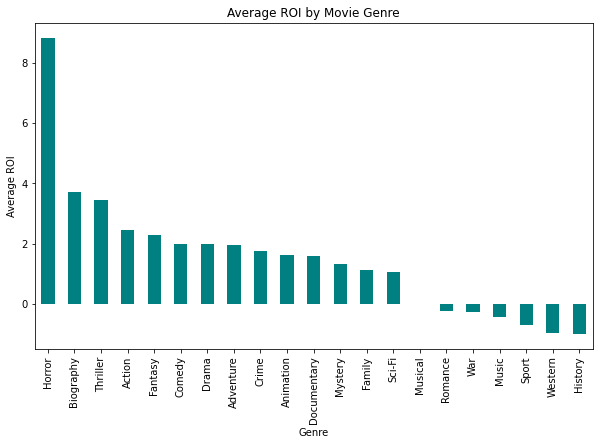

In [136]:
movies['main_genre'] = movies['genres'].str.split(',').str[0]
genre_profit = movies.groupby('main_genre')['roi'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
genre_profit.plot(kind='bar', color='teal')
plt.title('Average ROI by Movie Genre')
plt.ylabel('Average ROI')
plt.xlabel('Genre')
plt.show()


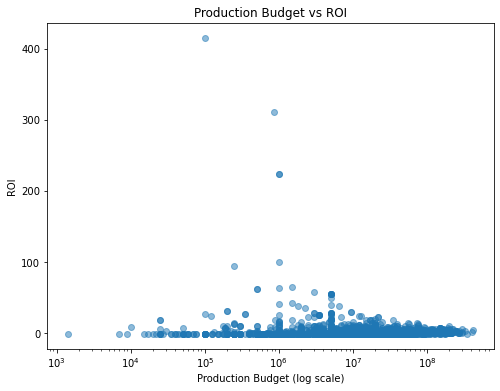

In [137]:
plt.figure(figsize=(8,6))
plt.scatter(movies['production_budget'], movies['roi'], alpha=0.5)
plt.xscale('log')
plt.title('Production Budget vs ROI')
plt.xlabel('Production Budget (log scale)')
plt.ylabel('ROI')
plt.show()


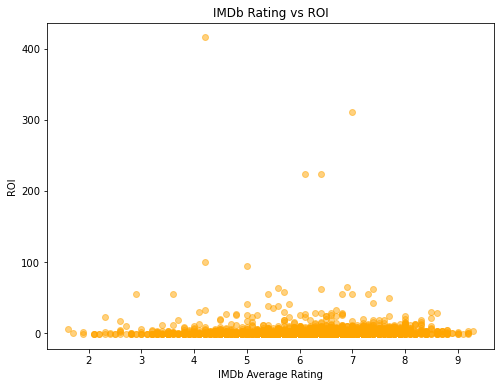

,averagerating,roi
averagerating,1.000000,0.010196
roi,0.010196,1.000000


In [138]:
plt.figure(figsize=(8,6))
plt.scatter(movies['averagerating'], movies['roi'], alpha=0.5, color='orange')
plt.title('IMDb Rating vs ROI')
plt.xlabel('IMDb Average Rating')
plt.ylabel('ROI')
plt.show()

# Optional correlation metric:
movies[['averagerating', 'roi']].corr()


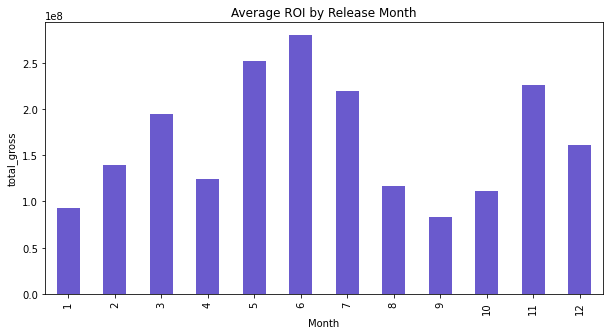

In [142]:
movies['release_month'] = pd.to_datetime(movies['release_date']).dt.month
month_roi = movies.groupby('release_month')['total_gross'].mean()

plt.figure(figsize=(10,5))
month_roi.plot(kind='bar', color='slateblue')
plt.title('Average ROI by Release Month')
plt.xlabel('Month')
plt.ylabel('total_gross')
plt.show()


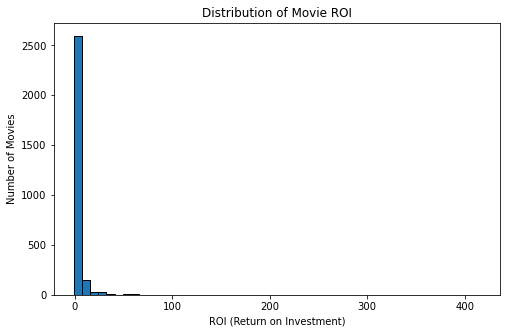

In [140]:


plt.figure(figsize=(8,5))
plt.hist(movies['roi'], bins=50, edgecolor='black')
plt.title('Distribution of Movie ROI')
plt.xlabel('ROI (Return on Investment)')
plt.ylabel('Number of Movies')
plt.show()


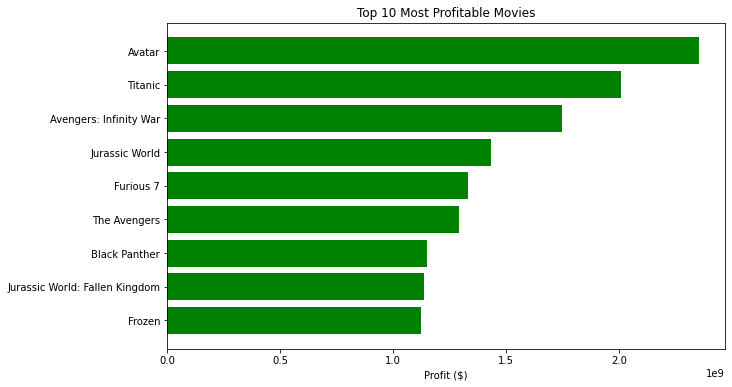

In [111]:
top10_profit = movies.sort_values('profit', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10_profit['primary_title'], top10_profit['profit'], color='green')
plt.title('Top 10 Most Profitable Movies')
plt.xlabel('Profit ($)')
plt.gca().invert_yaxis()
plt.show()


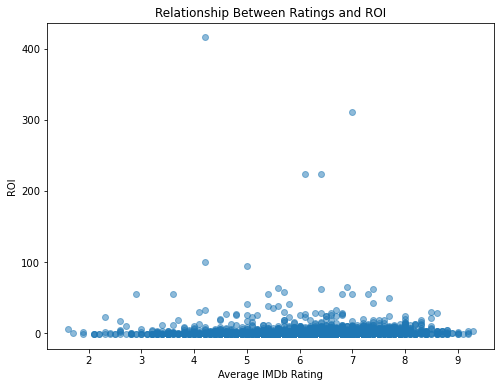

In [112]:
plt.figure(figsize=(8,6))
plt.scatter(movies['averagerating'], movies['roi'], alpha=0.5)
plt.title('Relationship Between Ratings and ROI')
plt.xlabel('Average IMDb Rating')
plt.ylabel('ROI')
plt.show()


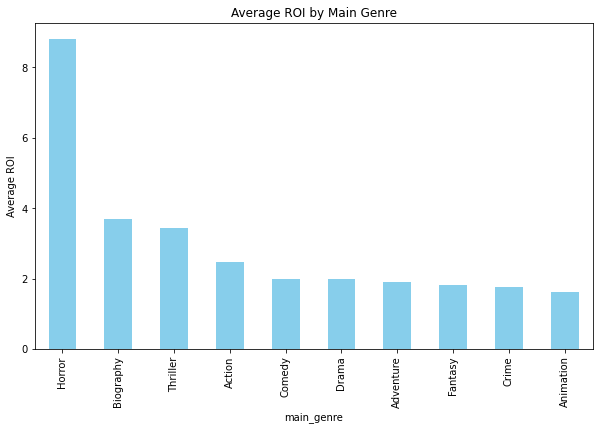

In [113]:
movies['main_genre'] = movies['genres'].str.split(',').str[0]
genre_roi = movies.groupby('main_genre')['roi'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
genre_roi.head(10).plot(kind='bar', color='skyblue')
plt.title('Average ROI by Main Genre')
plt.ylabel('Average ROI')
plt.show()


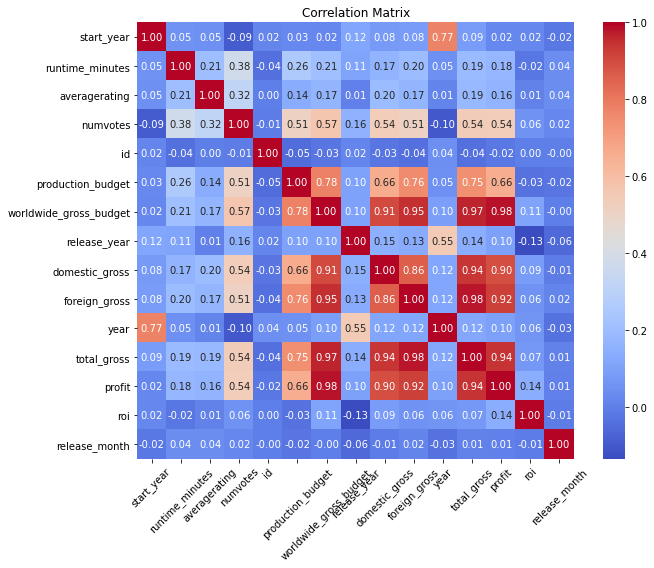

In [146]:
numeric_columns = movies.select_dtypes(include=[np.number]).columns

# Compute the correlation matrix
corr_matrix = movies[numeric_columns].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


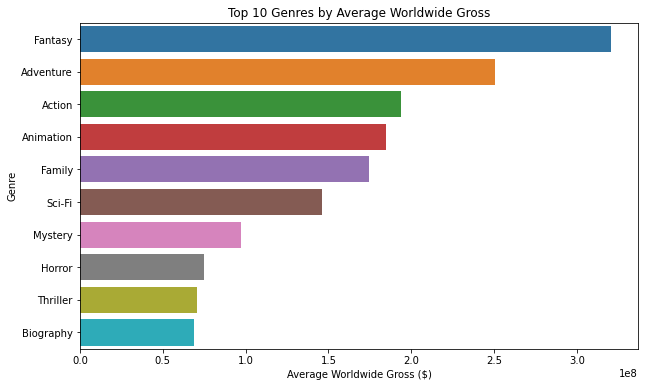

In [145]:
import seaborn as sns, matplotlib.pyplot as plt

movies['main_genre'] = movies['genres'].fillna('').str.split(',').str[0]
genre_group = movies.groupby('main_genre')['worldwide_gross_budget'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=genre_group.values, y=genre_group.index)
plt.title('Top 10 Genres by Average Worldwide Gross')
plt.xlabel('Average Worldwide Gross ($)')
plt.ylabel('Genre')
plt.show()


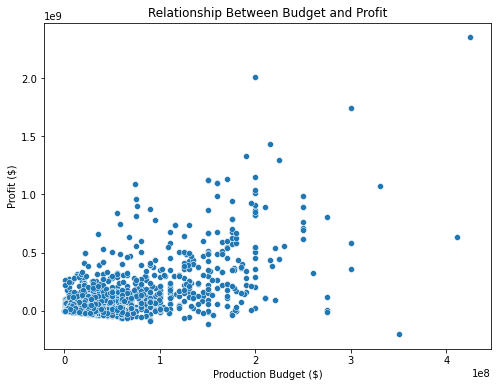

,production_budget,profit
production_budget,1.000000,0.657334
profit,0.657334,1.000000


In [143]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=movies, x='production_budget', y='profit')
plt.title('Relationship Between Budget and Profit')
plt.xlabel('Production Budget ($)')
plt.ylabel('Profit ($)')
plt.show()

movies[['production_budget', 'profit']].corr()


In [90]:
import pandas as pd
import numpy as np

# Assuming the provided DataFrame is named 'final_df'
# The genres column needs to be split by the comma ',' and then exploded.
genre_df = final_df.assign(genres=final_df['genres'].str.split(',')).explode('genres')
genre_df['genres'] = genre_df['genres'].str.strip() # Clean up any whitespace

# Filter out rows with missing ROI or zero production budget for meaningful analysis
genre_df_clean = genre_df.dropna(subset=['ROI'])
genre_df_clean = genre_df_clean[genre_df_clean['production_budget'] > 0].copy()

# Group by genre and calculate key performance indicators
genre_performance = genre_df_clean.groupby('genres').agg(
    avg_roi=('ROI', 'mean'),
    median_roi=('ROI', 'median'), # Median is often more robust against outliers
    avg_profit=('profit', 'mean'),
    movie_count=('movie_title', 'count'),
    avg_budget=('production_budget', 'mean')
).reset_index()

# Filter for reliability (e.g., only genres with at least 15 movies)
# **NOTE:** Adjust the sample_threshold based on the size of your final_df
sample_threshold = 15
reliable_genres = genre_performance[genre_performance['movie_count'] >= sample_threshold]
top_roi_genres = reliable_genres.sort_values(by='avg_roi', ascending=False).head(10)

print("Top 10 Genres by Average ROI (Filtered by 15+ movies):")
print(top_roi_genres)

Top 10 Genres by Average ROI (Filtered by 15+ movies):
       genres      avg_roi  median_roi    avg_profit  movie_count  \
11     Horror  1155.833073  294.404060  7.693326e+07          147   
14    Mystery  1041.278647  231.669132  7.222528e+07          119   
19   Thriller   677.495082  174.347100  9.217727e+07          243   
18      Sport   615.565536  151.581268  1.602076e+08           27   
12      Music   394.190662  195.561759  9.244978e+07           38   
16    Romance   371.104019  172.828467  8.038609e+07          179   
3   Biography   303.646546  155.041738  7.603405e+07          110   
7       Drama   303.582879  135.847867  6.942709e+07          684   
2   Animation   296.661476  215.325717  3.042839e+08          100   
17     Sci-Fi   296.098562  196.888675  2.428411e+08          119   

      avg_budget  
11  2.618435e+07  
14  2.790662e+07  
19  3.987315e+07  
18  4.381481e+07  
12  2.107632e+07  
16  2.937779e+07  
3   3.102182e+07  
7   3.500005e+07  
2   1.017650e+